In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout,LSTM
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dropout, Dense,LSTM

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import os

import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Potato leaf research/Potato Imbalanced Data .zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=3
img_size=256

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/Potato dataset",
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
)

Found 2152 files belonging to 3 classes.


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

In [ ]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
for feature, label in train_ds:
  x_train.append(feature)
  y_train.append(label)

In [ ]:
for feature, label in val_ds:
  x_val.append(feature)
  y_val.append(label)

In [ ]:
for feature, label in test_ds:
  x_test.append(feature)
  y_test.append(label)

In [ ]:
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test= np.array(x_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test=np.array(y_test)

In [ ]:
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_test:",x_test.shape)
print("y_test:",y_test.shape)
print("x_val:",x_val.shape)
print("y_val:",y_val.shape)

x_train: (54, 32, 256, 256, 3)
y_train: (54, 32)
x_test: (8, 32, 256, 256, 3)
y_test: (8, 32)
x_val: (6, 32, 256, 256, 3)
y_val: (6, 32)


In [ ]:
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
#Normalize the Data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test=np.array(x_test)/255

In [ ]:
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_test:",x_test.shape)
print("y_test:",y_test.shape)
print("x_val:",x_val.shape)
print("y_val:",y_val.shape)

x_train: (54, 32, 256, 256, 3)
y_train: (54, 32)
x_test: (8, 32, 256, 256, 3)
y_test: (8, 32)
x_val: (6, 32, 256, 256, 3)
y_val: (6, 32)


In [ ]:
#4 dIMENTION ( For Use Datagen)
x_train = np.array(x_train).reshape(1728,256,256, 3)
x_test = np.array(x_test).reshape(256,256,256, 3)
x_val = np.array(x_val).reshape(192,256,256, 3)

In [ ]:
datagen = ImageDataGenerator(
       featurewise_center=False,
       samplewise_center=False,
       featurewise_std_normalization=False,
       samplewise_std_normalization=False,
       zca_whitening=False,
       rotation_range = 90,
       zoom_range = 0.5,
       width_shift_range=0.2,
       height_shift_range=0.2,
       horizontal_flip = True,
)
datagen.fit(x_train)
datagen.fit(x_val)
datagen.fit(x_test)

In [ ]:
x_train = np.array(x_train).reshape(1728,1,256,256, 3)
x_test = np.array(x_test).reshape(256,1,256,256, 3)
x_val = np.array(x_val).reshape(192,1,256,256, 3)

In [ ]:
y_train=np.array(y_train).reshape(1728)
y_test=np.array(y_test).reshape(256)
y_val=np.array(y_val).reshape(192)

In [ ]:
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_test:",x_test.shape)
print("y_test:",y_test.shape)
print("x_val:",x_val.shape)
print("y_val:",y_val.shape)

x_train: (1728, 1, 256, 256, 3)
y_train: (1728,)
x_test: (256, 1, 256, 256, 3)
y_test: (256,)
x_val: (192, 1, 256, 256, 3)
y_val: (192,)


In [ ]:
# instantiate model
model = Sequential()

# add three time-distributed convolutional layers for feature extraction
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu'),input_shape=(1,256,256,3)))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(1, 1))))

model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(256, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(256, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# extract features and dropout
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))

# input to LSTM
model.add(LSTM(256, return_sequences=False, dropout=0.5))

# classifier with sigmoid activation for multilabel
model.add(Dense(3, activation='sigmoid'))

# compile the model with binary_crossentropy loss for multilabel
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics = ['accuracy'])

# look at the params before training
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 1, 254, 254, 64)   1792      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 1, 253, 253, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 1, 251, 251, 128   73856     
 stributed)                  )                                   
                                                                 
 time_distributed_3 (TimeDi  (None, 1, 125, 125, 128   0         
 stributed)                  )                                   
                                                                 
 time_distributed_4 (TimeDi  (None, 1, 123, 123, 128   1

In [ ]:
#opt = Adam(lr=0.01)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,epochs =3,validation_data = (x_val, y_val),shuffle=True,batch_size=32)

Epoch 1/3
54/54 [==============================] - 41s 407ms/step - loss: 0.8633 - accuracy: 0.5590 - val_loss: 0.4724 - val_accuracy: 0.8490
Epoch 2/3
54/54 [==============================] - 20s 380ms/step - loss: 0.4931 - accuracy: 0.8044 - val_loss: 0.1616 - val_accuracy: 0.9375
Epoch 3/3
54/54 [==============================] - 21s 381ms/step - loss: 0.5100 - accuracy: 0.8177 - val_loss: 0.4040 - val_accuracy: 0.8385


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

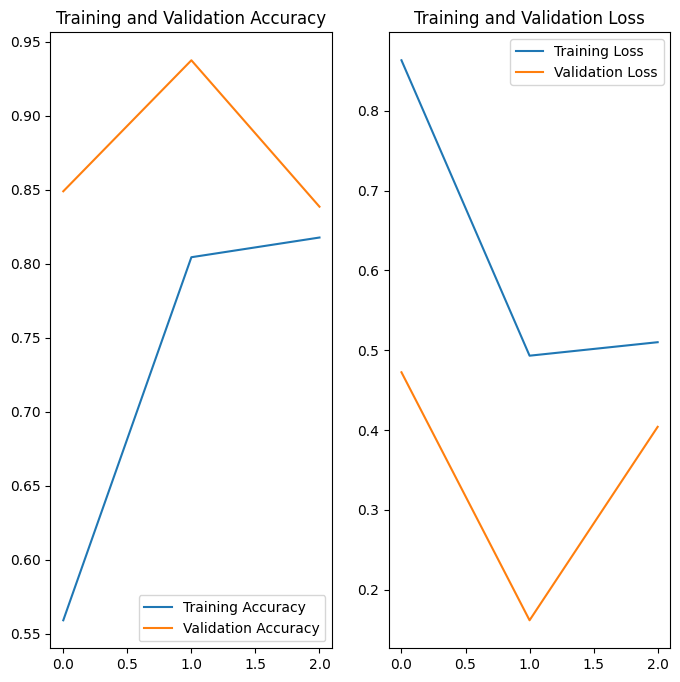

In [ ]:
# Accuracy AND loss Graph
EPOCHS=3
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
len(test_ds)

8

# Trying For Classification Report


In [ ]:
y_label_pred=[]
y_label=[]

In [ ]:
import pandas as pd

In [ ]:
y_actual = []
for img, label in test_ds:
    y_actual.extend(label.numpy())

In [ ]:
len(y_actual)

256

In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images.numpy())

    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class =class_names[np.argmax(predictions[0])]
    return predicted_class

In [ ]:
a=pd.DataFrame()
b =np.empty(shape=(255, 1))

In [ ]:
len(y_label_pred)

0

In [ ]:
for image, label in test_ds.take(1):  # Just take one sample to inspect
    print("Image shape:", image.shape)

Image shape: (8, 256, 256, 3)


In [ ]:
len(test_ds)

8

In [ ]:
8*32

256

In [ ]:
for batch_images, batch_labels in test_ds:
    for i in range(batch_images.shape[0]):  # Iterate over each image in the batch
        image = batch_images[i]

        # Add an extra dimension to make it compatible with the model's expected input
        image = tf.expand_dims(image, axis=0)  # Shape becomes (1, 256, 256, 3)
        image = tf.expand_dims(image, axis=0)  # Shape becomes (1, 1, 256, 256, 3)

        label = batch_labels[i]

        # Make predictions with your model for the individual image
        predictions = model.predict(image)

        # Process the predictions and labels as needed
        predicted_label = np.argmax(predictions[0])
        y_label_pred.append(predicted_label)

        # # Append actual label -> Use this if needed
        # actual_label = label.numpy()
        # y_actual.append(actual_label)

In [ ]:
len(y_label_pred)

256

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_label_pred))

              precision    recall  f1-score   support

           0       0.43      1.00      0.60       109
           1       0.00      0.00      0.00       129
           2       0.00      0.00      0.00        18

    accuracy                           0.43       256
   macro avg       0.14      0.33      0.20       256
weighted avg       0.18      0.43      0.26       256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']